# <span style="color:#0b486b">SIT307 - Assessment 2</span>

## <span style="color:#0b486b">Machine Learning</span>

Interpreting relevant data to predict future outcomes

### Import Libraries

In [2]:
#import regression techiniques
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

#importing classification techniques
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

#importing metric calculators
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from scipy.stats import zscore

#importing splitting techiniques
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import lightgbm as lgbm

### Load CSV

In [3]:
df = pd.read_csv('../Data/vehicles_clean.csv')
df.head()

,id,region,price,year,manufacturer,model,fuel,odometer,transmission,drive,type,paint_color,state
0,7088743681,greensboro,3995,2004.0,honda,element,gas,212526.0,automatic,fwd,SUV,orange,nc
1,7088741418,greensboro,10995,2014.0,chevrolet,traverse,gas,112383.0,automatic,fwd,SUV,black,nc
2,7088737004,greensboro,3995,2007.0,toyota,solara,gas,185123.0,automatic,fwd,convertible,black,nc
3,7088732376,greensboro,7995,2008.0,nissan,frontier,gas,162214.0,automatic,fwd,pickup,red,nc
4,7093461424,denver,7995,2010.0,chevrolet,silverado 1500 4wd,gas,194050.0,automatic,4wd,truck,white,co


### Check Data Cleaning

Text(0.5, 1.0, 'price vs year')

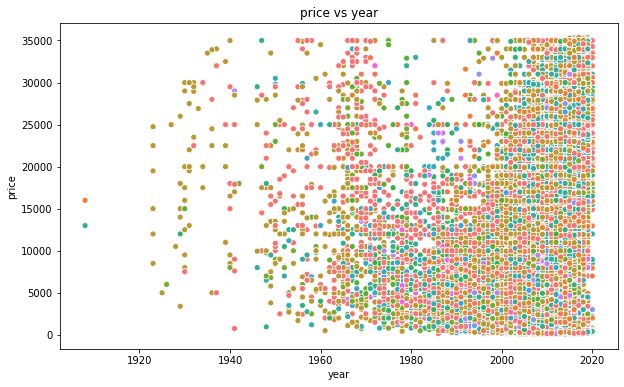

In [7]:
test_y_axis = 'price'
test_x_axis = 'year'
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_x_axis,y=test_y_axis, data=df, hue='manufacturer', legend=False)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

From this it is possible to see how the previous cleaning was not up to scratch.  If we look at the z score for each year and manufacturing grouping we can ensure that the data is of a higher standard.

In [8]:
def clean_col(df,item,val):
    df['zscore']=df.groupby(['year', 'manufacturer'])[item].transform(lambda x : zscore(x,ddof=1))
    df = df[df['zscore'] < val]
    df = df[df['zscore'] > -1*val]
    return df

In [9]:
cols_to_clean = {'price','odometer'}

df_clean = df
z_score_max = 1

for col in cols_to_clean:
    df_clean = clean_col(df_clean,col,z_score_max)


Text(0.5, 1.0, 'price vs year')

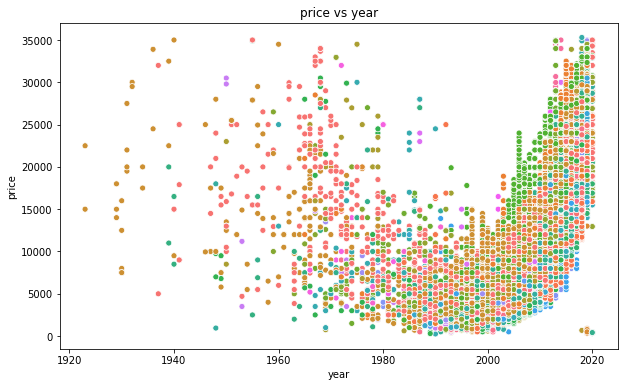

In [10]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_x_axis,y=test_y_axis, data=df_clean, hue='manufacturer', legend=False)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

Although hard to see, the addd cleaning of data has shown a clearer relationship n the data.  This can be taken further by showing a single manufacturer type as shown below.

Text(0.5, 1.0, 'price vs year')

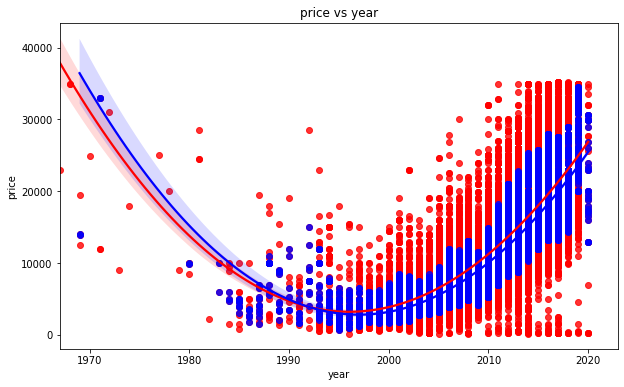

In [11]:
plt.figure(figsize=(10,6))
sns.regplot(x=test_x_axis,y=test_y_axis, data=df[df['manufacturer']=='toyota'], color='red', order=2)
sns.regplot(x=test_x_axis,y=test_y_axis, data=df_clean[df_clean['manufacturer']=='toyota'], color='blue', order=2)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

From the plot above it is clear that the relationship found between the data when predicting price is a non-linear correlation.  Thus it is necessary to explore different regression techniques and change the underlying variables in order to see what provide the most accurate results.

### Convert String to Numeric

In [43]:
man = df['manufacturer'].unique()
man.sort()
state = df['state'].unique()
state.sort()
dic={}
for count, val in enumerate(man):
    dic[val]=count
for count, val in enumerate(state):
    dic[val]=count
    
print(dic)

{'acura': 0, 'alfa-romeo': 1, 'audi': 2, 'bmw': 3, 'buick': 4, 'cadillac': 5, 'chevrolet': 6, 'chrysler': 7, 'datsun': 8, 'dodge': 9, 'ferrari': 10, 'fiat': 11, 'ford': 12, 'gmc': 13, 'harley-davidson': 14, 'honda': 15, 'hyundai': 16, 'infiniti': 17, 'jaguar': 18, 'jeep': 19, 'kia': 20, 'land rover': 21, 'lexus': 22, 'lincoln': 23, 'mazda': 24, 'mercedes-benz': 25, 'mercury': 26, 'mini': 27, 'mitsubishi': 28, 'nissan': 29, 'pontiac': 30, 'porche': 31, 'ram': 32, 'rover': 33, 'saturn': 34, 'subaru': 35, 'tesla': 36, 'toyota': 37, 'volkswagen': 38, 'volvo': 39, 'ak': 0, 'al': 1, 'ar': 2, 'az': 3, 'ca': 4, 'co': 5, 'ct': 6, 'dc': 7, 'de': 8, 'fl': 9, 'ga': 10, 'hi': 11, 'ia': 12, 'id': 13, 'il': 14, 'in': 15, 'ks': 16, 'ky': 17, 'la': 18, 'ma': 19, 'md': 20, 'me': 21, 'mi': 22, 'mn': 23, 'mo': 24, 'ms': 25, 'mt': 26, 'nc': 27, 'nd': 28, 'ne': 29, 'nh': 30, 'nj': 31, 'nm': 32, 'nv': 33, 'ny': 34, 'oh': 35, 'ok': 36, 'or': 37, 'pa': 38, 'ri': 39, 'sc': 40, 'sd': 41, 'tn': 42, 'tx': 43, 'ut'

In [44]:
df_clean_numeric = df_clean.replace(dic)
df_numeric = df.replace(dic)

In [45]:
def bin_column(df_bin):
    df_bin['odometer_bin'] = (df_bin['odometer'] // 5000) * 5000
    df_bin['price_bin'] = (df_bin['price'] // 500) * 500
    return df_bin

df_clean_numeric = bin_column(df_clean_numeric)
df_numeric = bin_column(df_numeric)

### Setup Training and Testing Splits

In [54]:
def return_train_splits(df_split):
    feature_cols = ['odometer_bin','year','manufacturer','state']
    X = df_split[feature_cols]
    y = df_split.price_bin

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return Xtrain, Xtest, ytrain, ytest

#find the correct splits for the pre and post added cleaning on dataframe
#results between the two show that the cleaned data returns more valid results
Xtrain, Xtest, ytrain, ytest = return_train_splits(df_clean_numeric)

In [55]:
Xtrain[:3]

,odometer_bin,year,manufacturer,state
94332,165000.0,1998.0,38,45
58898,200000.0,2005.0,29,9
140802,30000.0,2017.0,28,37


In [56]:
ytrain[:3]

94332     1500
58898     4500
140802    7500
Name: price_bin, dtype: int64

### Setup Accuracy Readings

In [57]:
def provide_accuracies(y,predictX):
    r2 = round(r2_score(y, predictX),4)
    mse = round(mean_squared_error(y, predictX),2)
    mae = round(median_absolute_error(y, predictX),2)
    
    print_string = "-----Regression Accuracies-----\n"
    print_string += "R Squared:\t\t {} \n".format(r2)
    print_string += "Mean Squared Error:\t {} \n".format(mse)
    print_string += "Median Absolute Error:\t {} \n".format(mae)
    print_string += "-------------------------------"
    
    print(print_string)
    
    return [r2,mse,mae]

### Setup Output Chart

In [58]:
row = ['R Squared','Mean Squared Error','Median Absolute Error']
data = {'Accuracy':row}
df_outcome = pd.DataFrame(data)
df_outcome

,Accuracy
0,R Squared
1,Mean Squared Error
2,Median Absolute Error


In [59]:
df_numeric

,id,region,price,year,manufacturer,model,fuel,odometer,transmission,drive,type,paint_color,state,zscore,odometer_bin,price_bin
0,7088743681,greensboro,3995,2004.0,15,element,gas,212526.0,automatic,fwd,SUV,orange,27,0.557358,210000.0,3500
1,7088741418,greensboro,10995,2014.0,6,traverse,gas,112383.0,automatic,fwd,SUV,black,27,0.494608,110000.0,10500
2,7088737004,greensboro,3995,2007.0,37,solara,gas,185123.0,automatic,fwd,convertible,black,27,0.477670,185000.0,3500
3,7088732376,greensboro,7995,2008.0,29,frontier,gas,162214.0,automatic,fwd,pickup,red,27,0.511729,160000.0,7500
4,7093461424,denver,7995,2010.0,6,silverado 1500 4wd,gas,194050.0,automatic,4wd,truck,white,5,0.683122,190000.0,7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218582,7088767324,greensboro,6695,2012.0,39,s60,gas,121898.0,automatic,fwd,sedan,silver,27,-0.113254,120000.0,6500
218583,7076307686,syracuse,6300,2014.0,29,altima,gas,85000.0,automatic,fwd,sedan,grey,34,0.111529,85000.0,6000
218584,7093462901,denver,5295,2006.0,2,a4 2.0t avant quattro,gas,150000.0,automatic,4wd,wagon,custom,5,0.514120,150000.0,5000
218585,7088752165,greensboro,13995,2016.0,29,frontier,gas,97545.0,automatic,4wd,pickup,silver,27,1.450249,95000.0,13500


### LightGBM

-----Regression Accuracies-----
R Squared:		 0.8141 
Mean Squared Error:	 9214119.45 
Median Absolute Error:	 1832.41 
-------------------------------


Text(0.5, 1.0, 'Feature Importance')

<Figure size 720x432 with 0 Axes>

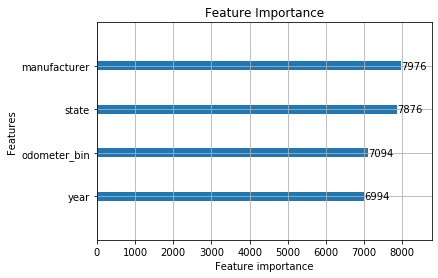

In [60]:
train_set = lgbm.Dataset(Xtrain, ytrain, silent=False)
valid_set = lgbm.Dataset(Xtest, ytest, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': 10,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelLGBM = lgbm.train(params, train_set = train_set, num_boost_round=1000,
                    early_stopping_rounds=50,verbose_eval=False, valid_sets=valid_set)

df_outcome['LGBM'] = provide_accuracies(ytest,modelLGBM.predict(Xtest))
    
plt.figure(figsize=(10,6))
lgbm.plot_importance(modelLGBM)
plt.title('Feature Importance')

### Random Forest Regressor

In [61]:
#def random_forest_regressor(X_train, X_test, y_train, y_test):
#    rf_regr = RandomForestRegressor(max_depth=10, random_state=0)
#    rf_regr.fit(X_train,y_train)
#    provide_accuracies(y_test,rf_regr.predict(X_test))

rf_regr = RandomForestRegressor(max_depth=10, random_state=0)
rf_regr.fit(Xtrain,ytrain)
df_outcome['RF'] = provide_accuracies(ytest,rf_regr.predict(Xtest))

-----Regression Accuracies-----
R Squared:		 0.8025 
Mean Squared Error:	 9792335.81 
Median Absolute Error:	 1927.12 
-------------------------------


### Decision Tree Regressor

In [62]:
#def decision_tree_regressor(X_train, X_test, y_train, y_test):
#    dt_regr = DecisionTreeRegressor(max_depth=10, random_state=0)
#    dt_regr.fit(X_train, y_train)
#    provide_accuracies(y_test,dt_regr.predict(X_test))

dt_regr = DecisionTreeRegressor(max_depth=10, random_state=0)
dt_regr.fit(Xtrain, ytrain)
df_outcome['DT'] = provide_accuracies(ytest,dt_regr.predict(Xtest))

-----Regression Accuracies-----
R Squared:		 0.7913 
Mean Squared Error:	 10343620.1 
Median Absolute Error:	 1977.84 
-------------------------------


### Linear Regression

In [63]:
#def linear_regressor(X_train, X_test, y_train, y_test):
#    lin_regr = LinearRegression()
#    lin_regr.fit(X_train, y_train)
#    provide_accuracies(y_test, lin_regr.predict(X_test))

lin_regr = LinearRegression()
lin_regr.fit(Xtrain, ytrain)
df_outcome['LR'] = provide_accuracies(ytest, lin_regr.predict(Xtest))

-----Regression Accuracies-----
R Squared:		 0.4843 
Mean Squared Error:	 25566497.59 
Median Absolute Error:	 3360.88 
-------------------------------


### Neural Network Regressor

In [64]:
#def mlp_regressor(X_train, X_test, y_train, y_test):
#    mlp_regr = MLPRegressor(hidden_layer_sizes=(30,30,30))
#    mlp_regr.fit(X_train, y_train)
#    provide_accuracies(y_test, mlp_regr.predict(X_test))

mlp_regr = MLPRegressor(hidden_layer_sizes=(30,30,30))
mlp_regr.fit(Xtrain, ytrain)
df_outcome['NN'] = provide_accuracies(ytest, mlp_regr.predict(Xtest))

-----Regression Accuracies-----
R Squared:		 0.4245 
Mean Squared Error:	 28530861.13 
Median Absolute Error:	 3944.19 
-------------------------------


In [68]:
col = ['LGBM','RF','DT','LR','NN']

for c in col:
    df_outcome[c] = df_outcome[c].apply(lambda x: '{:,}'.format(float(x)))

df_outcome

,Accuracy,LGBM,RF,DT,LR,NN
0,R Squared,0.81,0.8,0.79,0.48,0.42
1,Mean Squared Error,"9,214,119.45","9,792,335.81","10,343,620.1","25,566,497.59","28,530,861.13"
2,Median Absolute Error,"1,832.41","1,927.12","1,977.84","3,360.88","3,944.19"


### Test Different Parameters

In [306]:
def test_param(model, param, range_test):
    train_scores, valid_scores = validation_curve(model, Xtrain, ytrain, param_name=param, param_range=range_test, cv=10, scoring="r2")
    mean_train_score = np.mean(train_scores, axis=1) 
    mean_val_score   = np.mean(valid_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(max_depth_range, mean_train_score, color="blue", linewidth=1.5, label="Training")
    plt.plot(max_depth_range, mean_val_score, color="red", linewidth=1.5, label="Validation")
    plt.legend(loc="upper left")
    plt.xlabel("Tree-depth")
    plt.ylabel("Model Accuracy")
    plt.title("Accuracy comparison when changing {} for model {}".format(param,model.__class__.__name__))

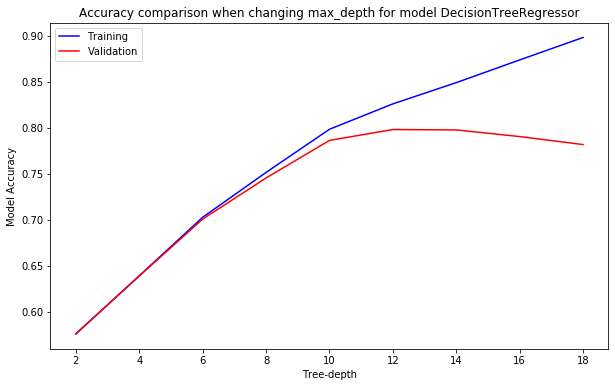

In [307]:
test_param(dt_regr, "max_depth", range(2, 20, 2))

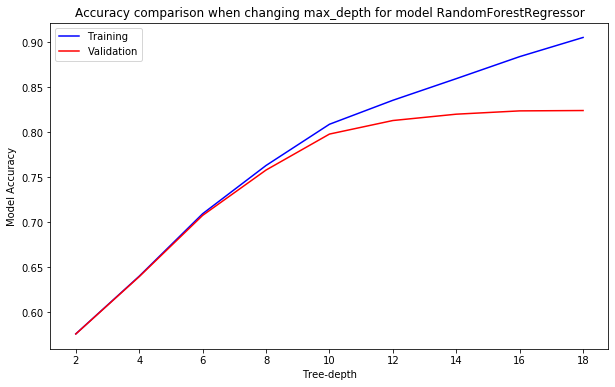

In [304]:
test_param(rf_regr, "max_depth", range(2, 20, 2))

# THE REST OF THIS NEEDS WORK

### Decision Tree Classification

In [231]:
treeclf = DecisionTreeClassifier(max_depth=5, random_state=0)
treeclf.fit(Xtrain, ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [232]:
treeclf.predict(Xtrain)[:5]

array([8500, 3500, 8500, 3500, 3500], dtype=int64)

In [233]:
ytrain[:5]

93517     21000
139098     3500
34962      5000
112444     2500
57843      4000
Name: price_bin, dtype: int64

In [234]:
score_r2 = r2_score(ytrain, treeclf.predict(Xtrain))
score_tree = treeclf.score(Xtrain, ytrain)
print(score_r2)
print(score_tree)


0.4207217639843073
0.10450297366185217


In [236]:
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy: {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))

Training accuracy: 0.10450297366185217
Testing accuracy: 0.1016903747756436


In [238]:
scores = cross_val_score(treeclf, Xtrain, ytrain, cv=10, scoring='accuracy')
print("Accuracy for each fold: {}".format(scores))
print("Mean Accuracy: {}".format(np.mean(scores)))

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy for each fold: [0.1        0.1065442  0.09598163 0.10298507 0.10045924 0.10551091
 0.10447761 0.10447761 0.10035595 0.1025376 ]
Mean Accuracy: 0.10233298385256473


In [243]:
max_depth_range = range(1, 20)

%time train_scores, valid_scores = validation_curve(treeclf, Xtrain, ytrain, param_name="max_depth", param_range=max_depth_range, cv=10, scoring="accuracy")

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Wall time: 19.3 s


In [244]:
valid_scores[:3]

array([[0.07646383, 0.07669346, 0.07623421, 0.07784156, 0.07451206,
        0.0749713 , 0.07761194, 0.07738232, 0.07808015, 0.07635779],
       [0.09196326, 0.09081515, 0.08668197, 0.09161883, 0.08874856,
        0.08897819, 0.09402985, 0.0912744 , 0.08795499, 0.09404065],
       [0.09667049, 0.1       , 0.09104478, 0.09988519, 0.09885189,
        0.09368542, 0.10149254, 0.1       , 0.09117005, 0.1005856 ]])

In [245]:
np.mean(valid_scores[:3], axis=1)

array([0.07661486, 0.09061059, 0.0973386 ])

Text(0.5, 1.0, 'Accuracy comparison of training/validation set')

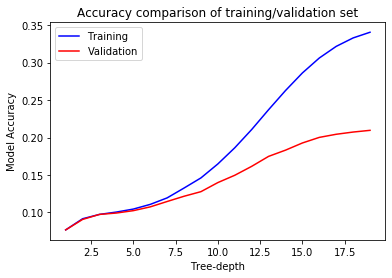

In [246]:
mean_train_score = np.mean(train_scores, axis=1) 
mean_val_score   = np.mean(valid_scores, axis=1)

plt.plot(max_depth_range, mean_train_score, color="blue", linewidth=1.5, label="Training")
plt.plot(max_depth_range, mean_val_score, color="red", linewidth=1.5, label="Validation")
plt.legend(loc="upper left")
plt.xlabel("Tree-depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy comparison of training/validation set")

### Regression

In [247]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(87098, 3)
(87098,)
(37329, 3)
(37329,)


In [248]:
lr_model = LinearRegression()

lr_model.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [249]:
ypredicts = lr_model.predict(Xtest)

print("The predicted sales:")
print(ypredicts[:5])
print()
print("The true sales:")
print(ytest[:5])

The predicted sales:
[14220.11703267 10217.85585286 17437.31966165 13870.59557429
 16138.01498545]

The true sales:
167987    12500
148572     5500
633       20500
71990     13500
196395    16500
Name: price_bin, dtype: int64


In [250]:
mse = np.mean((ypredicts - ytest) ** 2)

print("MSE: {}".format(mse))

MSE: 22323120.94759055


In [251]:
print(lr_model.intercept_)
print(lr_model.coef_)

print(zip(feature_cols, lr_model.coef_))

-1290627.2834055396
[-3.24898694e-02  6.49652338e+02 -2.76233369e+01]


In [255]:
def getMSErrorwithSize(model, train_sizes, Xtrain, ytrain, Xtest, ytest):
    
    # Initialize needed variables   
    model_mse   = np.zeros(len(train_sizes))  # storing model accuracy
    model_wts   = np.zeros([len(train_sizes), 4]) # storing model weights
    
    #Train our model with increasing data for each iteration
    for size in train_sizes:    
        Xsubtrain = Xtrain[0:size,:]
        ysubtrain = ytrain[0:size]
        model.fit(Xsubtrain, ysubtrain)
    
        # Test our model on fixed test set
        ypredicts = model.predict(Xtest)    
        
        index              = int(size/100)-1   
        model_mse[index]   = np.mean((ypredicts - ytest)**2)
        model_wts[index,:] = np.append(model.intercept_, model.coef_)  

    return model_mse, model_wts

def getR2ErrorwithSize(model, train_sizes, Xtrain, ytrain, Xtest, ytest):
    
    # Initialize needed variables   
    model_r2   = np.zeros(len(train_sizes))  # storing model accuracy
        
    #Train our model with increasing data for each iteration
    for size in train_sizes:    
        Xsubtrain = Xtrain[0:size,:]
        ysubtrain = ytrain[0:size]
        model.fit(Xsubtrain, ysubtrain)
    
        # Test our model on fixed test set
        ypredicts = model.predict(Xtest)    
        
        index              = int(size/100)-1   
        model_r2[index]   = r2_score(ypredicts,ytest)

    return model_r2

In [258]:
train_sizes = np.arange(100,1500,100) # training size from 10 to 140
#mse,weights = getMSErrorwithSize(lr_model,train_sizes, Xtrain.to_numpy(), ytrain.to_numpy(), Xtest.to_numpy(), ytest.to_numpy())
r2_exp = getR2ErrorwithSize(lr_model,train_sizes, Xtrain.to_numpy(), ytrain.to_numpy(), Xtest.to_numpy(), ytest.to_numpy())
print(train_sizes)

[ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400]


Text(0.5, 1.0, 'Effect of Data size on prediction error')

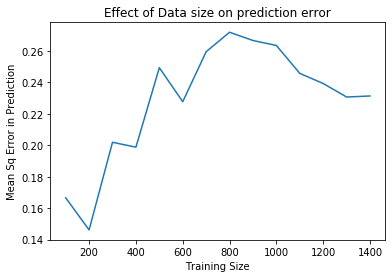

In [259]:
plt.plot(train_sizes, r2_exp)
plt.xlabel('Training Size')
plt.ylabel('Mean Sq Error in Prediction')
plt.title('Effect of Data size on prediction error')

### Machine Learning

In [ ]:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [194]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [195]:
mlp.fit(Xtrain,ytrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [196]:
predictions = mlp.predict(Xtest)

In [201]:
print("Training accuracy: {}".format(accuracy_score(ytest, mlp.predict(Xtest))))

Training accuracy: 0.04990812005645956


In [198]:
provide_accuracies(ytest, mlp.predict(Xtest))

-----Regression Accuracies-----
R Squared:		 -1.027 
Mean Squared Error:	 99359290.53 
Median Absolute Error:	 6000.0 
-------------------------------


[-1.0270405538837428, 99359290.52704467, 6000.0]

In [199]:
print(confusion_matrix(ytest,predictions))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [200]:
print(classification_report(ytest,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
         500       0.00      0.00      0.00        30
        1000       0.00      0.00      0.00        73
        1500       0.00      0.00      0.00       359
        2000       0.00      0.00      0.00       409
        2500       0.00      0.00      0.00      1048
        3000       0.00      0.00      0.00       770
        3500       0.00      0.00      0.00      1655
        4000       0.00      0.00      0.00       828
        4500       0.05      1.00      0.10      1874
        5000       0.00      0.00      0.00       827
        5500       0.00      0.00      0.00      1837
        6000       0.00      0.00      0.00       679
        6500       0.00      0.00      0.00      1810
        7000       0.00      0.00      0.00       574
        7500       0.00      0.00      0.00      1620
        8000       0.00      0.00      0.00       541
        8500       0.00    

C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
